# Comparison of Snow Cover Area to Discharge data 

This Notebook is a follow-on the Validation Exercise Notebook. Here, we showcase the comparison between the Snow Cover Area Time-series and The Time-series Discharge Data at the Stations within the Catchment area of interest.

In [2]:
# import essential libraries
from datetime import date

import openeo
import numpy as np 
import xarray as xr
import rioxarray as rio 

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import pandas as pd
import geopandas as gpd
import folium
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox, bbox_to_dimensions, geometry)

In [3]:
# TODO: Get correctly format time-series datasets e.g. ZARR format,
# TODO: Display time-series of snow cover per catchment station, 
# TODO: Extract snow-cover values per station and convert to DataFrame for easy comparison


## Configuration and Set up

In [4]:
config = SHConfig()
config.sh_client_id = %env SH_CLIENT_ID
config.sh_client_secret = %env SH_CLIENT_SECRET

In [5]:
conn = openeo.connect('https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production')
# conn = openeo.connect('https://openeo-dev.sinergise.com/testing')

In [6]:
conn = conn.authenticate_basic(username=config.sh_client_id, password=config.sh_client_secret)

In [7]:
conn.describe_account()

{'default_plan': 'enterprise-s',
 'info': {'sh_userinfo': {'aid': '7c7cd3b4-7996-4abb-a465-b41dac60e107',
   'aud': 'c7210eb0-591c-4b42-b355-a654a71051b5',
   'd': {'1': {'ra': {'rag': 7}, 't': 14001}},
   'did': 1,
   'email': 'hub+mooc@eox.at',
   'exp': 1695201860,
   'jti': '3e4717d6-7f0f-4251-96ae-7abbfa6eed38',
   'name': 'hub+mooc@eox.at',
   'org': '3d31397f-770a-4f98-9358-84e918491745',
   'sid': 'cec96b9c-d86c-4876-9076-49ca1804448e',
   'sub': '58a6b718-458b-4493-bfe9-14229b83c310'}},
 'name': 'hub+mooc@eox.at',
 'user_id': '58a6b718-458b-4493-bfe9-14229b83c310'}

## Load Collections
- Load the Sentinel L2A Connection from SentinelHub Backend into a DataCube

In [8]:
collection      = 'SENTINEL2_L2A_SENTINELHUB'
# spatial_extent  = {'west':11.020833,'east':11.366667,'south':46.653599,'north':46.954167,'crs':4326}
spatial_extent  = {'west':11.08,'east':11.11,'south':46.77,'north':46.79,'crs':4326}

temporal_extent = ["2018-02-01", "2018-06-30"]
# temporal_extent = ["2018-02-01", "2018-02-15"]
bands           = ['B03', 'B11', 'CLM']

In [22]:
s2cube = conn.load_collection(collection,
                          spatial_extent=spatial_extent,
                          bands=bands,
                          temporal_extent=temporal_extent)

In [23]:
s2cube

## Instantiate the NDSI Process Graph

In [24]:
green = s2cube.band("B03")
swir = s2cube.band("B11")
ndsi = (green - swir) / (green + swir)
ndsi

In [25]:
# show process graph
ndsi.print_json()

{
  "process_graph": {
    "loadcollection1": {
      "process_id": "load_collection",
      "arguments": {
        "bands": [
          "B03",
          "B11",
          "CLM"
        ],
        "id": "SENTINEL2_L2A_SENTINELHUB",
        "spatial_extent": {
          "west": 11.08,
          "east": 11.11,
          "south": 46.77,
          "north": 46.79,
          "crs": 4326
        },
        "temporal_extent": [
          "2018-02-01",
          "2018-06-30"
        ]
      }
    },
    "reducedimension1": {
      "process_id": "reduce_dimension",
      "arguments": {
        "data": {
          "from_node": "loadcollection1"
        },
        "dimension": "bands",
        "reducer": {
          "process_graph": {
            "arrayelement1": {
              "process_id": "array_element",
              "arguments": {
                "data": {
                  "from_parameter": "data"
                },
                "index": 0
              }
            },
            "arra

## Instantiate the Ansynchronous Processing of the Process Graph

In [26]:
# create a batch job
ndsi = ndsi.save_result(format="GTiff")
ndsi_job = ndsi.create_job(title="Snow Cover Area Computation")
# ndsi_job
conn.list_jobs()

[{'created': '2023-08-30T14:23:04Z',
  'description': None,
  'id': 'afcb9fc6-3856-465e-bbaf-34a5455ae936',
  'status': 'finished',
  'title': 'Cloud Mask Extraction'},
 {'created': '2023-08-30T08:32:20Z',
  'description': None,
  'id': 'd8d55912-fe19-4462-94d4-9452b24e036b',
  'status': 'finished',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T08:02:29Z',
  'description': None,
  'id': '842df6e5-4a39-4143-a25e-a92c2013211f',
  'status': 'created',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-09-06T09:10:36Z',
  'description': None,
  'id': '7c3c94b6-93d7-4dbb-b2f5-bb6bf2f9584e',
  'status': 'error',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-29T13:00:45Z',
  'description': None,
  'id': '45d0055c-7097-43a7-9da9-d8d5bd6cfa75',
  'status': 'created',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T08:26:45Z',
  'description': None,
  'id': 'da8560fc-3c6e-493b-af28-8e6ef2af9d6b',
  'status': 'error',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T09:03:50Z',
  'description': None,
  'id': 'aed870b0-2f6e-44b3-aa6a-94b6ca87ff75',
  'status': 'error',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-09-06T09:10:00Z',
  'description': None,
  'id': 'a3819e0f-2fb3-442a-b202-c73a74be2b87',
  'status': 'created',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T09:39:58Z',
  'description': None,
  'id': 'daea34c4-41b5-482d-af5c-859e0c8eab84',
  'status': 'error',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-10T08:36:19Z',
  'description': None,
  'id': '696b8218-a139-4d07-9cb2-6931a4e8ca1a',
  'status': 'finished',
  'title': 'ndsi_max'},
 {'created': '2023-08-29T13:04:39Z',
  'description': None,
  'id': '917291d8-e14f-4830-a75d-8dcccab2578c',
  'status': 'error',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T07:28:01Z',
  'description': None,
  'id': 'c5d96350-e07e-420f-9046-49a70a2a7f9d',
  'status': 'error',
  'title': None},
 {'created': '2023-09-06T13:08:55Z',
  'description': None,
  'id': '58798b3a-9cab-4840-a187-c875592ad530',
  'status': 'running',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T08:18:12Z',
  'description': None,
  'id': 'abde4582-32f6-4c7e-8fad-24a57f51bedc',
  'status': 'finished',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T08:02:33Z',
  'description': None,
  'id': '128d7353-1bc2-47ba-b421-b752b9c495f9',
  'status': 'finished',
  'title': None},
 {'created': '2023-09-06T13:01:43Z',
  'description': None,
  'id': '22e45773-ffbb-41b3-9dc7-5c252fbdd417',
  'status': 'error',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T08:45:34Z',
  'description': None,
  'id': 'b489b49a-56ac-458c-a7fd-d37cdb7d2ea1',
  'status': 'finished',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-09-06T09:20:18Z',
  'description': None,
  'id': 'bfe91952-b1cb-4e55-9894-7690dbd652ff',
  'status': 'error',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-30T14:21:05Z',
  'description': None,
  'id': '1fca63f9-7d36-4395-a7b7-e34550e02bfe',
  'status': 'created',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-08-29T13:00:00Z',
  'description': None,
  'id': '3c05733f-3b20-4e18-a21d-518b9d98751d',
  'status': 'created',
  'title': None},
 {'created': '2023-08-30T07:27:41Z',
  'description': None,
  'id': '3f739580-60f4-4f45-885c-0220b2a3f73e',
  'status': 'created',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-05-24T08:30:02Z',
  'description': None,
  'id': '856308cf-cdcc-4f5e-85a5-49f7e966f043',
  'status': 'finished',
  'title': 's2_spatial_temporal_slicing'},
 {'created': '2023-09-06T10:14:14Z',
  'description': None,
  'id': '318e3e34-8d2a-4a9c-abc0-65da2f41c2fd',
  'status': 'error',
  'title': 'Snow Cover Area Computation'},
 {'created': '2023-09-06T09:25:42Z',
  'description': None,
  'id': 'be30cd13-cc71-4fa5-b527-86bf3505efea',
 

In [ ]:
ndsi_job.start_and_wait()

In [14]:
ndsi_job.status()

'created'

In [15]:
# view failing job
# fail_job_id = "daea34c4-41b5-482d-af5c-859e0c8eab84"
# conn.job(fail_job_id)

In [16]:
# ndsi_job.start_and_wait()
# ndsi_job.execute_batch()
# # # job = ndsi.send_job()
# # # if job:
# # #     print(job.job_id)
# # # else:
# # #     print("Job ID is None")
# # ndsi_job.start()

In [ ]:
results = ndsi_job.get_results()
results
# The result metadata describes the spatio-temporal properties of the result and is in fact a valid STAC item.
# results.get_metadata()

In [ ]:
# save ndsi results
results.download_files("data/ndsi")

## Cloud Mask Extraction

In [27]:
# ndsi_job.logs()
cloud_mask= s2cube.band("CLM")
cloud_mask = cloud_mask.save_result(format="GTiff")
cloud_mask_job = cloud_mask.create_job(title="Cloud Mask Extraction")
cloud_mask_job

<BatchJob job_id='df5695e2-b4f9-412c-bdf9-abaae41319d1'>

In [20]:
# save cloud mask
cloud_mask_job.start_and_wait()

0:00:00 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': send 'start'
0:00:25 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': queued (progress N/A)
0:00:30 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': queued (progress N/A)
0:00:36 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': queued (progress N/A)
0:00:44 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:00:54 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:01:06 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:01:22 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:01:41 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:02:05 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:02:35 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:03:12 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:03:59 Job 'afcb9fc6-3856-465e-bbaf-34a5455ae936': running (progress N/A)
0:04:57 Job 'afcb9fc6-3856-465e-bbaf-3

<BatchJob job_id='afcb9fc6-3856-465e-bbaf-34a5455ae936'>

In [23]:
cloud_results = cloud_mask_job.get_results()
cloud_results.download_files("data/clm")

[PosixPath('data/clm/8b8f5365-26f0-47f8-a239-9dba6922a2c6/32TPS_5_1/default.tif'),
 PosixPath('data/clm/8b8f5365-26f0-47f8-a239-9dba6922a2c6/32TPS_6_1/default.tif'),
 PosixPath('data/clm/job-results.json')]

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<xarray.DataArray (band: 58, y: 1000, x: 1000)>
[58000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58
  * x            (x) float64 6.5e+05 6.5e+05 6.5e+05 ... 6.6e+05 6.6e+05 6.6e+05
  * y            (y) float64 5.19e+06 5.19e+06 5.19e+06 ... 5.18e+06 5.18e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

## Load Datasets

In [1]:
import rioxarray as rio

# load saved ndsi
sample_tiff_1 = rio.open_rasterio("data/ndsi/3c26fefc-0f22-4b2b-8ccc-b5cd0b706935/32TPS_5_1/default.tif",  masked=True)
sample_tiff_2 = rio.open_rasterio("data/ndsi/3c26fefc-0f22-4b2b-8ccc-b5cd0b706935/32TPS_6_1/default.tif",  masked=True)

sample_tiff_1

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<xarray.DataArray (band: 58, y: 1000, x: 1000)>
[58000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58
  * x            (x) float64 6.5e+05 6.5e+05 6.5e+05 ... 6.6e+05 6.6e+05 6.6e+05
  * y            (y) float64 5.19e+06 5.19e+06 5.19e+06 ... 5.18e+06 5.18e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [2]:
sample_tiff_2

<xarray.DataArray (band: 58, y: 1000, x: 1000)>
[58000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58
  * x            (x) float64 6.6e+05 6.6e+05 6.6e+05 ... 6.7e+05 6.7e+05 6.7e+05
  * y            (y) float64 5.19e+06 5.19e+06 5.19e+06 ... 5.18e+06 5.18e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [10]:
# xndsi = sample_tiff_1.to_zarr("sample_ndsi.zarr")

In [12]:
# sample_xndsi = xr.open_zarr("sample_ndsi.zarr")
# sample_xndsi

<xarray.Dataset>
Dimensions:                        (band: 58, y: 1000, x: 1000)
Coordinates:
  * band                           (band) int64 1 2 3 4 5 6 ... 54 55 56 57 58
  * x                              (x) float64 6.5e+05 6.5e+05 ... 6.6e+05
  * y                              (y) float64 5.19e+06 5.19e+06 ... 5.18e+06
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float32 dask.array<chunksize=(8, 125, 250), meta=np.ndarray>
    spatial_ref                    int64 ...

<xarray.Dataset>
Dimensions:                        (band: 58, y: 1000, x: 1000)
Coordinates:
  * band                           (band) datetime64[ns] 2018-02-01 ... 2018-...
  * x                              (x) float64 6.5e+05 6.5e+05 ... 6.6e+05
  * y                              (y) float64 5.19e+06 5.19e+06 ... 5.18e+06
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float32 dask.array<chunksize=(8, 125, 250), meta=np.ndarray>
    spatial_ref                    int64 ...

In [51]:
sample_tiff_1 = sample_tiff_1.rio.write_crs("epsg:4326", inplace=True)
ndsi_xds = sample_tiff_1.to_dataset(name="snowmap")

In [4]:
# load saved cloud mask
cloud_mask_ras = rio.open_rasterio("data/clm/8b8f5365-26f0-47f8-a239-9dba6922a2c6/32TPS_5_1/default.tif")
cloud_mask_ras

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<xarray.DataArray (band: 58, y: 1000, x: 1000)>
[58000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58
  * x            (x) float64 6.5e+05 6.5e+05 6.5e+05 ... 6.6e+05 6.6e+05 6.6e+05
  * y            (y) float64 5.19e+06 5.19e+06 5.19e+06 ... 5.18e+06 5.18e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [52]:
snow_map = ndsi_xds.snowmap > 0.4

In [53]:
ndsi_xds["snowmap_cloudless"] = (ndsi_xds.snowmap > 0.4).where(cloud_mask_ras==0)
# No Snow = 0; Snow = 1; Cloud=NaN

In [54]:
ndsi_xds

<xarray.Dataset>
Dimensions:            (band: 58, x: 1000, y: 1000)
Coordinates:
  * band               (band) int64 1 2 3 4 5 6 7 8 ... 51 52 53 54 55 56 57 58
  * x                  (x) float64 6.5e+05 6.5e+05 6.5e+05 ... 6.6e+05 6.6e+05
  * y                  (y) float64 5.19e+06 5.19e+06 ... 5.18e+06 5.18e+06
    spatial_ref        int64 0
Data variables:
    snowmap            (band, y, x) float32 0.5902 0.5905 ... 0.3841 0.3971
    snowmap_cloudless  (band, y, x) float64 nan nan nan nan ... nan nan nan nan

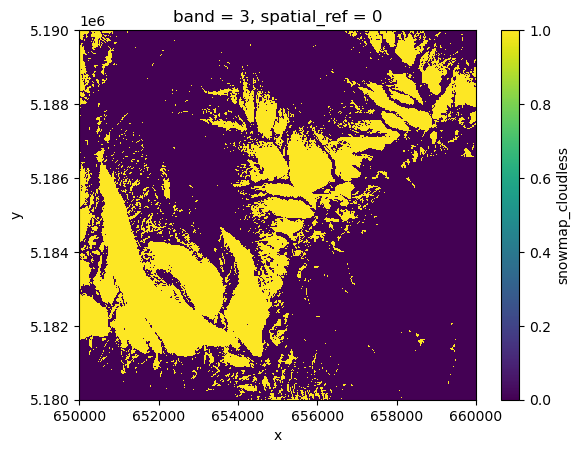

In [14]:
ndsi_xds.snowmap_cloudless.sel(band=3).plot.imshow()

In [50]:
# mask dataset by geometry
# catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# shapefile = catchment_outline.iloc[0].geometry
# shapefile
# shapes = [feature["geometry"] for feature in shapefile]
import fiona

with fiona.open('data/catchment_outline.geojson', "r", crs="epsg:4326") as shapefile:
    print(shapefile.crs)
    shapes = [feature["geometry"] for feature in shapefile]

# xds = rio.open_rasterio("data/ndsi/3c26fefc-0f22-4b2b-8ccc-b5cd0b706935/32TPS_6_1/default.tif",
#                         masked=True).rio.clip(shapes,
#                                               from_disk=True)
# ndsi_xds

EPSG:4326


### SCA vs Discharge Comparison

In [25]:
## Data Loading
# - Load Catchment area,
# - Load Discharge Data, 
# - Load Snow Cover Area Data.

In [1]:
# NOTE: check if necessary to load catchment area
# from shapely.geometry import box 
# # mask by the catchment geometry
# catchment_geom = catchment_outline.iloc[0].geometry
# print(catchment_geom)
# print("\n")
# print()
# snowmap_masked = snow_map.rio.clip(catchment_geom)
# mask_dataset_by_geometry(snow_map, catchment_outline.iloc[0].geometry)

# catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# m = folium.Map(location=[catchment_outline.centroid.y, catchment_outline.centroid.x])
# folium.GeoJson(data=catchment_outline.to_json(), name='catchment').add_to(m)
# m

# # bbox = catchment_outline.bounds.iloc[0]

### Load Discharge Data

In [5]:
# # load discharge data 
# discharge_ds = pd.read_csv('data/ADO_DSC_ITH1_0025.csv', sep=',', index_col='Time', parse_dates=True)
# discharge_ds.head()

,discharge_m3_s
Time,
1994-01-01 01:00:00,4.03
1994-01-02 01:00:00,3.84
1994-01-03 01:00:00,3.74
1994-01-04 01:00:00,3.89
1994-01-05 01:00:00,3.80


In [8]:
# # load snow cover area data
# TODO: recompute snow area in percentage in this notebook
# sca_ts = pd.read_csv("data/s2_sca_ts_cloudfree.csv", sep=',', index_col='time', parse_dates=True)
# sca_ts.head()

,snow_percent
time,
2018-02-08 10:11:53,79.586701
2018-02-11 10:25:59,74.475260
2018-02-13 10:15:59,68.060348
2018-02-21 10:20:33,71.934766
2018-02-28 10:10:21,68.030633


<Axes: ylabel='Discharge (m$^3$/s)'>

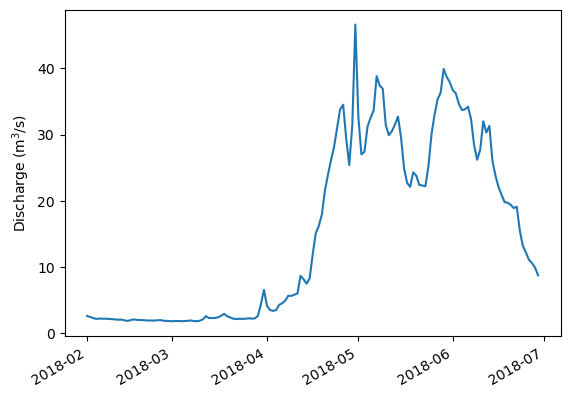

In [6]:
# start_date = date(2018, 2, 1)
# end_date = date(2018, 6, 30)
# # filter discharge data to start and end dates and explore
# discharge_ds = discharge_ds.loc[start_date:end_date]
# discharge_ds.discharge_m3_s.plot(label="Discharge", xlabel='', ylabel='Discharge (m$^3$/s)')

<Axes: ylabel='Discharge (m$^3$/s)'>

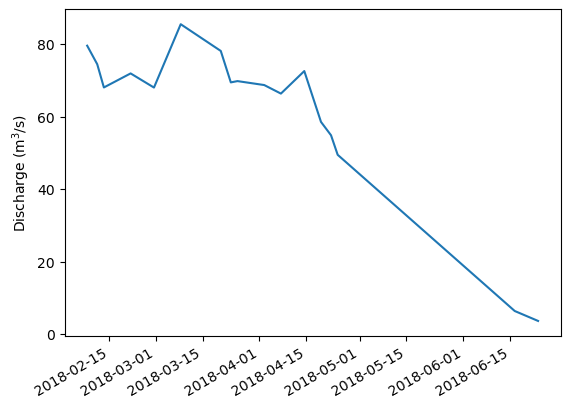

In [8]:
# # sca_ts = sca_ts.loc[start_date:end_date]
# sca_ts.snow_percent.plot(label="Discharge", xlabel='', ylabel='Discharge (m$^3$/s)')

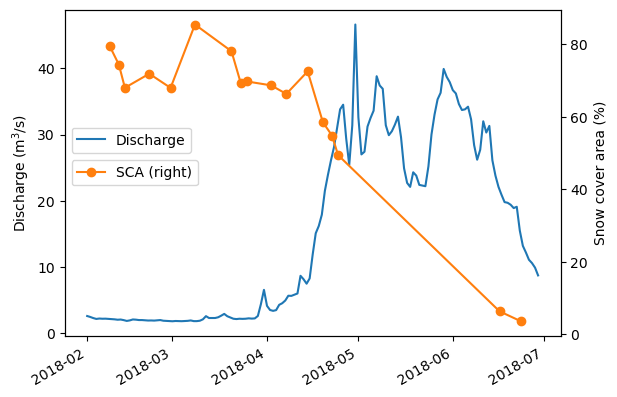

In [10]:
# ax1 = dsc.discharge_m3_s.plot(label='Discharge', xlabel='', ylabel='Discharge (m$^3$/s)')
# ax2 = sca_ts.snow_percent.plot(marker='o', secondary_y=True, label='SCA', xlabel='', ylabel='Snow cover area (%)')
# ax1.legend(loc='center left', bbox_to_anchor=(0, 0.6))
# ax2.legend(loc='center left', bbox_to_anchor=(0, 0.5))
# plt.show()